<a href="https://colab.research.google.com/github/Gzaborey/python_applications_classifier/blob/main/applications_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import sklearn.model_selection as sk_ms
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [2]:
%matplotlib inline

In [3]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Defining necessary functions to preprocess the data

def process_text(text):

  """Removes punctuation, whitespases, stopwords, english words, short words and digits.
     Returns list of words."""

  stemmer = SnowballStemmer("russian")
  eng_regex = re.compile(r"[a-zA-Z]")

  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  processed_words = [stemmer.stem(word.lower()) for word in nopunc.split()\
                      if word.lower() not in stopwords.words("russian")\
                      and word.lower() not in stopwords.words("english")\
                      and word.lower().isalpha()\
                      and len(word.lower()) > 4\
                      and word.lower() not in "".join(eng_regex.findall(word.lower()))]
  return processed_words 


def validate_name(string_to_validate, name_data):

  """Checks if given name is common. 
      If given name is not common (does not appear in a database of names) 
      it is considered invalid i.e. fake name."""

  name_validity = 0
  for word in string_to_validate.lower().split():
    if word in name_data:
      name_validity = 1
      break
    else:
      name_validity = 0
  return name_validity


def validate_phone_number(phone_number):

  """Checks if given phone number is from Ukraine."""

  temp1 = [char for char in phone_number if (char not in string.punctuation \
                                             and char is not ' ')]
  temp2 = ''.join(temp1)
  if len(temp2) > 12 or len(temp2) < 9:
    return 0
  else:
    for char in range(7):
      temp1.pop()
    temp2 = ''.join(temp1)
    pattern1 = re.compile(r"(380|0|)")
    first_condition = temp2[-3::-1][::-1] in pattern1.findall(temp2[-3::-1][::-1])
    pattern2 = re.compile(r"(39|67|68|96|97|98|50|66|95|99|63|93|91|92|94)")
    second_condition = temp2[-1:-3:-1][::-1] in pattern2.findall(temp2[-1:-3:-1][::-1])
    if first_condition and second_condition:
      return 1
    else:
      return 0

# **Preparing the data**

## Loading the data and constructing features

In [5]:
# Loading data

email_data = pd.read_excel("https://github.com/Gzaborey/python_applications_classifier/blob/main/data/email_data.xlsx?raw=true")
email_data = email_data.drop(["Unnamed: 0"], axis=1, errors="ignore")
email_data = email_data.drop_duplicates()
email_data = email_data.rename(columns={"add": "message"})
email_data = email_data.sample(frac=1)
email_data = email_data.reset_index(drop=True)
email_data["message"] = email_data["message"].astype("str")

In [6]:
# Acquaintance with the data

email_data.head()

,name,phone,email,message,is_spam
0,222,222,NaN,333,1
1,Лукашова Анна,952893676,NaN,nan,0
2,Fomin Aleksandr Alekseevich,674812290,aleksandr.fomin@gmail.com,111,0
3,uijibalute,88172376177,oaeixt@otnis.jonjamail.com,nan,1
4,ecaigimeem,84163726533,umaikosu@ifowe.jonjamail.com,nan,1


In [7]:
# Observing data (looking for missing values, etc)

print(email_data["is_spam"].value_counts())
print()
print(email_data.isna().sum())
print()
print(email_data.dtypes)

1    342
0    214
Name: is_spam, dtype: int64

name        1
phone       1
email      36
message     0
is_spam     0
dtype: int64

name       object
phone      object
email      object
message    object
is_spam     int64
dtype: object


In [8]:
# Filling in missing values

email_data = email_data.fillna('')
email_data["message"] = email_data["message"].replace("nan", "")
print(email_data.isna().sum())

name       0
phone      0
email      0
message    0
is_spam    0
dtype: int64


In [9]:
# Loading dataframe of common names

names_data = pd.read_csv("https://raw.githubusercontent.com/Gzaborey/python_applications_classifier/main/data/names_dataframe.csv", index_col="Unnamed: 0")
names_list = [str(name).lower() for name in names_data.iloc[:, -1]]

In [10]:
# Looking at the size of a names database

print(len(names_list))

97974


In [11]:
# Constructing features ('email_domain', 'valid_first_name' and 'valid_phone_number')

email_data.insert(loc=3, column="email_domain", 
                               value=email_data["email"].apply(lambda x: x.lower().split("@")[-1].strip()))

email_data.insert(loc=1, column="valid_first_name", 
                               value=email_data.name.astype("str")\
                              .apply(lambda x: validate_name(x, names_list)))

email_data.insert(loc=3, column="valid_phone_number", 
                               value=email_data.phone.astype("str").apply(lambda x: validate_phone_number(x)))

## Dividing the data into test, train and validation sets

In [12]:
# Shuffling dataframe rows 

email_data = email_data.sample(frac=1)
email_data = email_data.reset_index(drop=True)

X = email_data.drop("is_spam", axis=1)
y = email_data.is_spam

email_data.head()

,name,valid_first_name,phone,valid_phone_number,email,email_domain,message,is_spam
0,olyabibykova,0,82651551247,0,olyabibykova@yandex.ru,yandex.ru,,1
1,samuelMus,0,86149551378,0,c.oo.per.a.l.e.x.an.dr.h.o.m.ewor.k.8.4.8.@gma...,gmail.c,,1
2,contttjeb,0,83341271966,0,fedonovandronja1988@rambler.ru,rambler.ru,,1
3,Нил,1,+38 (063) 744 2447,1,bbamblbe@gmail.com,gmail.com,,0
4,Кучеренко Руслан,1,669087208,1,kmr200116@gmail.com,gmail.com,,0


In [13]:
print("Number of entries is", len(email_data))

Number of entries is 556


In [14]:
# Splitting data into train, valiation and test sets

X_rest, X_test, y_rest, y_test = sk_ms.train_test_split(X, y, test_size=0.2, stratify=y)

X_rest = X_rest.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_rest = y_rest.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train, X_valid, y_train, y_valid = sk_ms.train_test_split(X_rest, y_rest, test_size= 0.3, stratify=y_rest)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

X_valid.head()

,name,valid_first_name,phone,valid_phone_number,email,email_domain,message
0,olyshka,0,88151848742,0,32galy@mail.ru,mail.ru,
1,LeniAreriuche,0,83321697722,0,terrance.riley@inbox.ru,inbox.ru,gislaved
2,uyuducolo,0,84574274532,0,axojif@otnis.jonjamail.com,otnis.jonjamail.com,
3,Дмитрий,1,79123456150,0,noilacenma1982@mail.ru,mail.ru,Здравствуйте. Оказываю полный спектр юридическ...
4,Donaldlqe,0,87875352762,0,u.serzalevs.ki.j.a2.2.201@gmail.com\n,gmail.com,Привет господа \nБурение скважин Бурение скваж...


In [15]:
print("Number of training examples", len(y_train))
print("Number of validation examples", len(y_valid))
print("Number of testing examples", len(y_test))

Number of training examples 310
Number of validation examples 134
Number of testing examples 112


# **Building and training the model**

## Converting "email_domain" and "message" columns into vectors.

In [16]:
#Preparing the data vectorizer

email_dom_vectorizer = CountVectorizer()
email_dom_vectorizer.fit(email_data.email_domain)
email_dom_vectorized_train = email_dom_vectorizer.transform(X_train.email_domain)
email_dom_vectorized_valid = email_dom_vectorizer.transform(X_valid.email_domain)
email_dom_vectorized_test = email_dom_vectorizer.transform(X_test.email_domain)

email_message_vectorizer = CountVectorizer(analyzer=process_text)
email_message_vectorizer.fit(email_data.message)
email_message_vectorized_train = email_message_vectorizer.transform(X_train.message)
email_message_vectorized_valid = email_message_vectorizer.transform(X_valid.message)
email_message_vectorized_test = email_message_vectorizer.transform(X_test.message)


In [17]:
 #email_message_vectorizer.get_feature_names()

## Building Naive Bayes model for "email_domain" column analysis

In [18]:
# Naive Bayes model for "email_domain" column analysis training and tuning

NB_dom_model_params = [i/100 for i in range(1, 101)]
f1_scores = {}
for i in range(len(NB_dom_model_params)):
  NB_dom_model = MultinomialNB(alpha=NB_dom_model_params[i])
  NB_dom_model.fit(email_dom_vectorized_train, y_train)
  NB_dom_predictions = NB_dom_model.predict(email_dom_vectorized_valid)
  f1_score = sk_metrics.f1_score(y_valid, NB_dom_predictions, average="binary")
  f1_scores[NB_dom_model_params[i]] = f1_score


In [19]:
# Determining the optimal value for "alpha" hyperparameter.

best_score = 0
best_alpha = 0

for alpha, score in f1_scores.items():
    if score >= best_score:
      best_alpha = alpha
      best_score = score

print("Optimal 'alpha' hyperparameter value:", best_alpha)

print("F1 score for optimal hyperparameter value:", f1_scores[best_alpha])


Optimal 'alpha' hyperparameter value: 0.28
F1 score for optimal hyperparameter value: 0.810126582278481


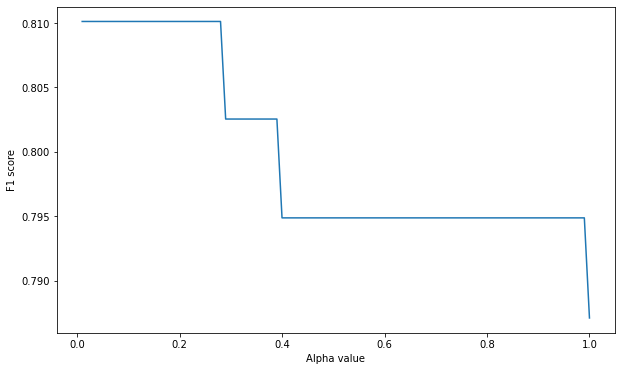

In [20]:
# Naive Bayes model for "email_domain" column analysis efficiency plot

x = []
y = []

for key, value in f1_scores.items():
  x.append(key)
  y.append(value)

fig = plt.figure(figsize=(10,6))

plt.plot(x, y)

plt.xlabel("Alpha value")
plt.ylabel("F1 score")

plt.show()


In [21]:
# Training the model using the optimal "alpha" hyperparameter value

NB_dom_model = MultinomialNB(alpha=best_alpha)

NB_dom_model.fit(email_dom_vectorized_train, y_train)

NB_dom_predictions = NB_dom_model.predict(email_dom_vectorized_valid)

NB_dom_train_proba = NB_dom_model.predict_proba(email_dom_vectorized_train)[:, 1]
NB_dom_valid_proba = NB_dom_model.predict_proba(email_dom_vectorized_valid)[:, 1]


In [22]:
# NB model performance results

print(sk_metrics.classification_report(y_valid, NB_dom_predictions))
print()
print("Accuracy score:", sk_metrics.accuracy_score(y_valid, NB_dom_predictions))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73        52
           1       0.84      0.78      0.81        82

    accuracy                           0.78       134
   macro avg       0.77      0.77      0.77       134
weighted avg       0.78      0.78      0.78       134


Accuracy score: 0.7761194029850746


## Building Naive Bayes model for "message" column analysis

In [23]:
# Naive Bayes model for "message" column analysis training and tuning

NB_mes_model_params = [i/100 for i in range(1, 201)]
f1_scores = {}
for i in range(len(NB_mes_model_params)):
  NB_mes_model = MultinomialNB(alpha=NB_mes_model_params[i])
  NB_mes_model.fit(email_message_vectorized_train, y_train)
  NB_mes_predictions = NB_mes_model.predict(email_message_vectorized_valid)
  f1_score = sk_metrics.f1_score(y_valid, NB_mes_predictions)
  f1_scores[NB_mes_model_params[i]] = f1_score
  

In [24]:
# Determining the optimal value for "alpha" hyperparameter.

best_score = 0
best_alpha = 0

for alpha, score in f1_scores.items():
    if score >= best_score:
      best_alpha = alpha
      best_score = score

print("Optimal 'alpha' hyperparameter value:", best_alpha)

print("F1 score for optimal hyperparameter value:", f1_scores[best_alpha])


Optimal 'alpha' hyperparameter value: 0.08
F1 score for optimal hyperparameter value: 0.7684210526315789


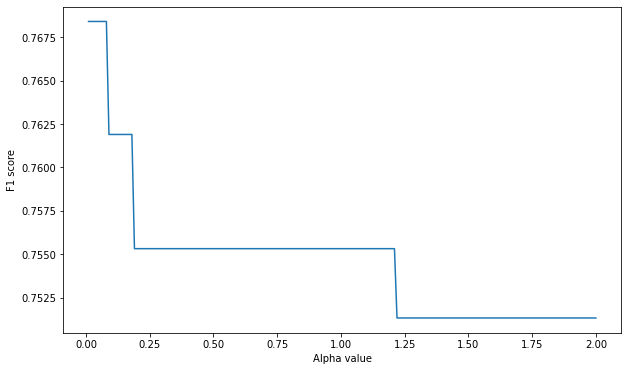

In [25]:
# Naive Bayes model for "message" column analysis efficiency plot

x = []
y = []

for key, value in f1_scores.items():
  x.append(key)
  y.append(value)

fig = plt.figure(figsize=(10,6))

plt.plot(x, y)

plt.xlabel("Alpha value")
plt.ylabel("F1 score")

plt.show()


In [26]:
# Training the model using the optimal "alpha" hyperparameter value

NB_mes_model = MultinomialNB(alpha=best_alpha)

NB_mes_model.fit(email_message_vectorized_train, y_train)

NB_mes_predictions = NB_mes_model.predict(email_message_vectorized_valid)

NB_mes_train_proba = NB_mes_model.predict_proba(email_message_vectorized_train)[:, 1]
NB_mes_valid_proba = NB_mes_model.predict_proba(email_message_vectorized_valid)[:, 1]

In [27]:
# NB model performance results

print(sk_metrics.classification_report(y_valid, NB_mes_predictions))
print()
print("Accuracy score:", sk_metrics.accuracy_score(y_valid, NB_mes_predictions))

              precision    recall  f1-score   support

           0       0.65      0.33      0.44        52
           1       0.68      0.89      0.77        82

    accuracy                           0.67       134
   macro avg       0.66      0.61      0.60       134
weighted avg       0.67      0.67      0.64       134


Accuracy score: 0.6716417910447762


## Building Logistic Regression model for predicting the validity of applications

In [28]:
# Data to train and tune LR

X_train = X_train.loc[:, ["valid_first_name", "valid_phone_number"]]
X_train = pd.concat([X_train, pd.Series(NB_dom_train_proba, name="domain_validity_proba")], axis=1)
X_train = pd.concat([X_train, pd.Series(NB_mes_train_proba, name="message_validity_proba")], axis=1)

X_valid_temp = X_valid.loc[:, ["valid_first_name", "valid_phone_number"]]
X_valid_temp = pd.concat([X_valid_temp, pd.Series(NB_dom_valid_proba, name="domain_validity_proba")], axis=1)
X_valid_temp = pd.concat([X_valid_temp, pd.Series(NB_mes_valid_proba, name="message_validity_proba")], axis=1)

X_train.head()

,valid_first_name,valid_phone_number,domain_validity_proba,message_validity_proba
0,0,0,0.696737,0.616129
1,0,0,0.970037,0.616129
2,1,1,0.153292,0.616129
3,0,0,0.998605,0.616129
4,0,0,0.991660,0.616129


In [ ]:
# Logistic Regression сlassifier training and tuning

LR_model = LogisticRegression(max_iter=300)
LR_params = {"penalty": ["l1", "l2"],
             "C": [i/100 for i in range(1, 1001, 10)],
             "solver": ["liblinear", "saga"]}

clf = sk_ms.GridSearchCV(LR_model, LR_params)

clf.fit(X_train, y_train)

In [30]:
print("Optimal set of hyperparameters:", clf.best_params_)

Optimal set of hyperparameters: {'C': 0.11, 'penalty': 'l2', 'solver': 'liblinear'}


In [31]:
# Logistic Regression classifier performance results

LR_predictions = clf.predict(X_valid_temp)

print(sk_metrics.classification_report(y_valid, LR_predictions))
print()
print("Accuracy score:", sk_metrics.accuracy_score(y_valid, LR_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        52
           1       0.99      0.99      0.99        82

    accuracy                           0.99       134
   macro avg       0.98      0.98      0.98       134
weighted avg       0.99      0.99      0.99       134


Accuracy score: 0.9850746268656716


# **Testing the model on test data set**

In [32]:
# NB model analysis of "email_domain" column

NB_dom_predictions = NB_dom_model.predict_proba(email_dom_vectorized_test)[:, 1]

In [33]:
# NB model analysis of "message" column

NB_mes_predictions = NB_mes_model.predict_proba(email_message_vectorized_test)[:, 1]

In [34]:
# Preparing data for LR

temp_df = X_test.loc[:, ["valid_first_name", "valid_phone_number"]]
temp_df = pd.concat([temp_df, pd.Series(NB_dom_predictions, name="domain_validity_proba")], axis=1)
temp_df = pd.concat([temp_df, pd.Series(NB_mes_predictions, name="message_validity_proba")], axis=1)

temp_df.head()

,valid_first_name,valid_phone_number,domain_validity_proba,message_validity_proba
0,1,1,0.153292,0.000365
1,0,0,0.153292,0.616129
2,1,1,0.153292,0.000005
3,1,1,0.017646,0.616129
4,1,1,0.153292,0.005835


In [35]:
# Logistic Regression performance results on a test dataset

LR_predictions = clf.predict(temp_df)

print(sk_metrics.classification_report(y_test, LR_predictions))
print("Accuracy score:", sk_metrics.accuracy_score(y_test, LR_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        69

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112

Accuracy score: 1.0


In [36]:
# Inspecting performance of a model on a test dataset visually

inspect_df = pd.concat([X_test, pd.Series(LR_predictions, name="prediction")], axis=1)
inspect_df = pd.concat([inspect_df, y_test], axis=1)
inspect_df.head(10)

,name,valid_first_name,phone,valid_phone_number,email,email_domain,message,prediction,is_spam
0,Заноза Светлана,1,380631000000,1,sa.zanoza@gmail.com,gmail.com,Будет ли возможность обучения онлайн?,0,0
1,StephenPealf,0,87597338877,0,em7evg@gmail.com,gmail.com,,1,1
2,Заикин Андрей Викторович (папа),1,672949941,1,masterkrovlia2017@gmail.com,gmail.com,"Нужно прособеседовать, т.к. возможно на Юнити",0,0
3,Екатерина Лабутина,1,380980000000,1,kabutina@ukr.net,ukr.net,,0,0
4,Наталья Танчук,1,978033778,1,natali.komarnitska@gmail.com,gmail.com,Хочу у вас учиться,0,0
5,monyya,0,85876247953,0,shisha71@list.ru,list.ru,,1,1
6,monyya,0,88658147571,0,shisha71@list.ru,list.ru,"Заказать seo поисковую оптимизацию сайта, Зака...",1,1
7,minilia,0,86835326898,0,axoplarly@ahmail.xyz,ahmail.xyz,,1,1
8,Пилаева Наталья,1,506007045,1,0506007045@ukr.net,ukr.net,Добрый вечер! Мы хотели бы заниматься дистанци...,0,0
9,niczorrrr,0,88891222667,0,alex2131@gmail.com,gmail.com,,1,1
